# Gabor Filter

In [1]:
import numpy as np
import cv2 as cv
from math import pi
from matplotlib import pyplot as plt
from numpy.fft import fft2, fftshift
from mpl_toolkits.mplot3d import axes3d, Axes3D
from multiprocessing.pool import ThreadPool
%matplotlib inline

In [2]:
def gabor_fn(sigma, theta, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

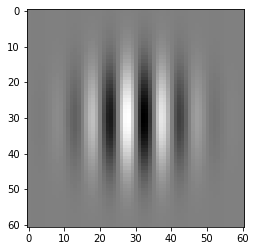

In [3]:
gabor_img = gabor_fn(sigma=10., theta=pi/2, Lambda=10, psi=pi/2, gamma=1.)
plt.imshow(gabor_img, cmap="gray")

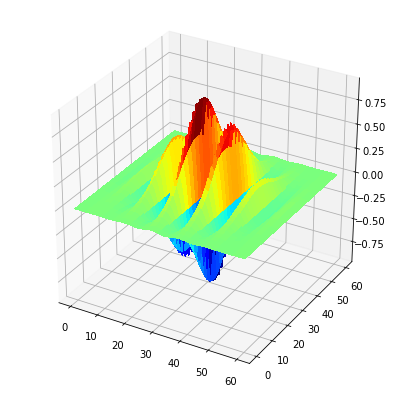

In [4]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection='3d')
X = np.arange(gabor_img.shape[0])
Y = np.arange(gabor_img.shape[1])
X, Y = np.meshgrid(Y, X)
ax.plot_surface(X, Y, gabor_img, cmap="jet", linewidth=1, antialiased=False)

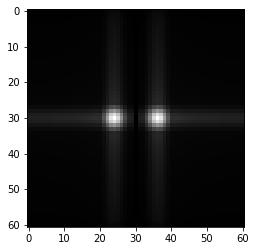

In [5]:
def visualize(x, gamma=1):
    x = np.absolute(x)
    x = x.min()
    x = x/x.max()
    x = np.power(x, gamma)
    x *= 255
    return x.astype(np.uint8)

gabor_fft = fftshift(fft2(gabor_img, axes=(0,1)))
plt.imshow(visualize(gabor_fft, 0.25), cmap="gray")

# Application

Magic Filter:

1. Create several different Gabor filter

2. Create accum matrix (same size of input image)

3. Filter the original image

4. Compare two original and filtered image by bit, copy higher value one to accum matrix

5. repeat step3 and step4

In [49]:
def build_filters():
    filters = []
    ksize = 31
    # 16 filters with different theta
    for theta in np.arange(0, np.pi, np.pi / 4):
        kern = cv.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

In [7]:
def process_threaded(img, filters, threadn = 8):
    accum = np.zeros_like(img)
    def f(kern):
        return cv.filter2D(img, cv.CV_8UC3, kern)
    pool = ThreadPool(processes=threadn)
    for fimg in pool.imap_unordered(f, filters):
        np.maximum(accum, fimg, accum)
    return accum

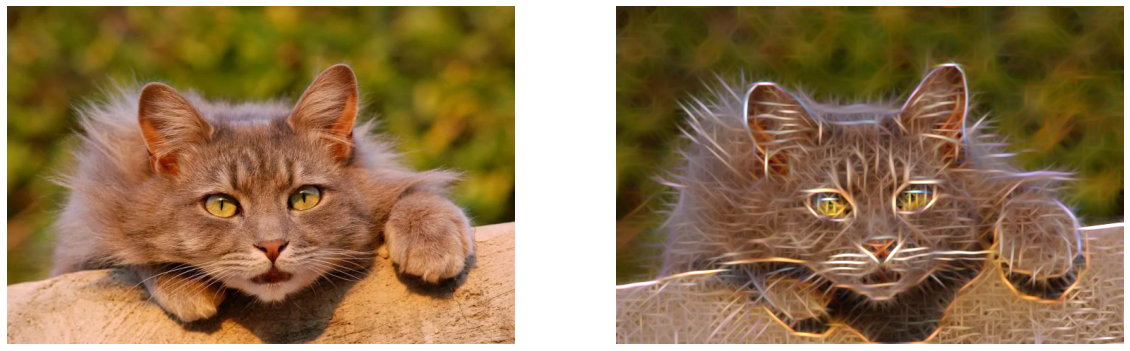

In [50]:
img_fn = 'cat1.jpg'
img = cv.imread(img_fn)
img = img[:, :, ::-1]
plt.figure(figsize=[20,20])
plt.subplot(121)
plt.imshow(img)
plt.axis("off")
filters = build_filters()
res2 = process_threaded(img, filters)
plt.subplot(122)
plt.axis("off")
plt.imshow(res2)

## Test

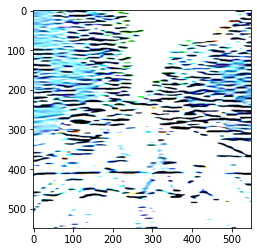

In [37]:
img = cv.imread('AbbeyRoad.jpg')
img = img[:,:,::-1]
ksize = 31
filter = cv.getGaborKernel((ksize, ksize), 4.0, pi/2, 10.0, 0.5, 0, ktype=cv.CV_32F)
img_fil = cv.filter2D(img,cv.CV_8UC3,filter)
plt.imshow(img_fil)